# Regression Analysis of Coronavirus Data
### Anton Zverev

Last edited: 04/17/20


.

In [1]:
import pandas as pd
import numpy as np
import inspect
from scipy import stats
from scipy import special
from math import sqrt
import time

import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

# Data Importation & Cleaning

First, import raw data:

In [2]:
data_url_states = 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv'
data_url_states_pop = 'https://people.sc.fsu.edu/~jburkardt/datasets/census/census_2010.txt'
data_url_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data_url_global_pop = 'https://raw.githubusercontent.com/datasets/population/master/data/population.csv'
filepath_state_quar = 'data/States_Quarantine_Dates.xlsx' # tabulated manually from https://www.nga.org/coronavirus/#states
filepath_global_quar = 'data/Global_Quarantine_Dates.csv' # downloaded from https://en.wikipedia.org/wiki/National_responses_to_the_2019–20_coronavirus_pandemic

raw_df_states = pd.read_csv(data_url_states) # state-by-state data
raw_df_global = pd.read_csv(data_url_global) # country-by-country data
global_populations = pd.read_csv(data_url_global_pop) # world population data
state_populations = pd.read_fwf(data_url_states_pop,header=None,thousands=',') # state population data
#state_actions = pd.read_excel('data/CoronavirusStateActionsChart_10April2020.xlsx') # state law data
global_quarantines = pd.read_csv(filepath_global_quar) # country quarantine date data
state_quarantines = pd.read_excel(filepath_state_quar) # state quarantine date data


The population dataframes also needs to be cleaned up a little:

In [3]:
global_populations = global_populations[global_populations['Year']==2016]
idx = global_populations[global_populations['Country Name']=='Afghanistan'].index.to_list()[0]
global_populations = global_populations.loc[idx:,['Country Name','Value']]
global_populations.rename(columns={'Country Name':'Country','Value':'pop'},inplace=True)
global_populations.set_index('Country',inplace=True)

In [4]:
state_populations.set_index(0,inplace=True)
state_populations.rename(columns={1:'pop'},inplace=True)
state_populations.index.rename('State',inplace=True)

As do `global_quarantines`, and `state_quarantines`:

In [5]:
global_quarantines.columns = global_quarantines.iloc[0,:]
global_quarantines.drop(index=0,inplace=True)
global_quarantines = global_quarantines[['Country','Start date']]
global_quarantines.drop(global_quarantines.tail(1).index,inplace=True)
global_quarantines['Start date'] = global_quarantines['Start date'].str.extract(pat='(.+)\[')
global_quarantines['Start date'] = pd.to_datetime(global_quarantines['Start date'], format='%Y-%m-%d')
global_quarantines['Start date'] = global_quarantines['Start date'].dt.dayofyear
global_quarantines = global_quarantines.groupby(by='Country').agg('median')
global_quarantines.rename(columns={'Start date':'Q_day'},inplace=True)

In [6]:
state_quarantines.set_index('State',inplace=True)
state_quarantines['Q_day'] = (state_quarantines['Declared Quarantine'].dt.dayofyear +
       state_quarantines['Declared State of Emergency'].dt.dayofyear) / 2


I will reformat the global data into a new dataframe `global_cumulative` so that it's easier to use and intepret. I'll also only focus on the top 40 most affected countries.

In [7]:
raw_df_global.drop(columns=['Province/State','Lat','Long'],inplace=True)
raw_df_global.replace('US', 'United States',inplace=True)
raw_df_global = raw_df_global.groupby(by='Country/Region',as_index=True).agg(sum)
top_countries = raw_df_global.iloc[:,-1].sort_values(ascending=False).index[:50] # find top 50 countries

global_cumulative = raw_df_global.loc[top_countries,:].T # only take top countries, and transpose
global_cumulative.index.rename('date',inplace=True)
global_cumulative.columns.name = None
global_cumulative.index = pd.to_datetime(global_cumulative.index, format='%m/%d/%y') # fix timestamp
global_cumulative.sort_values(by='date',ascending=False,inplace=True)

global_cumulative.head(3)

,United States,Spain,Italy,France,Germany,United Kingdom,China,Iran,Turkey,Belgium,...,Singapore,Belarus,Ukraine,Qatar,Dominican Republic,Panama,Luxembourg,Finland,Colombia,Egypt
date,,,,,,,,,,,,,,,,,,,,,
2020-04-16,667801,184948,168941,147091,137698,104145,83403,77995,74193,34809,...,4427,4204,4161,4103,3755,3751,3444,3369,3233,2673
2020-04-15,636350,177644,165155,134582,134753,99483,83356,76389,69392,33573,...,3699,3728,3764,3711,3614,3574,3373,3237,3105,2505
2020-04-14,607670,172541,162488,131361,131359,94845,83306,74877,65111,31119,...,3252,3281,3372,3428,3286,3472,3307,3161,2979,2350


The raw state data is in a format that's hard to use, so I will convert it into a dataframe `states_cumulative` indexed by the date, with a separate column for each state:

In [8]:
states_list = raw_df_states['state'].unique() # list of state abbreviations (50 states + 5 territories + DC)

raw_df_states['date'] = pd.to_datetime(raw_df_states['date'], format='%Y%m%d') # fix timestamp
raw_df_states = raw_df_states[['date','state','positive']] #extract the columns I care about

In [9]:
states_cumulative = raw_df_states[raw_df_states['state']=='AK'][['date','positive']]
states_cumulative.reset_index(drop=True,inplace=True)

for s in states_list:
    state_data = raw_df_states[raw_df_states['state']==s]['positive']
    states_cumulative[s] = state_data.reset_index(drop=True)

states_cumulative.set_index('date',inplace=True) # index by date
states_cumulative.drop(columns='positive',inplace=True)
states_cumulative.fillna(value=0,inplace=True) # nan values will mess up the regression later

states_cumulative.head(3)

,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
2020-04-16,300.0,4345.0,1620.0,0.0,4234.0,26182.0,8280.0,15884.0,2350.0,2075.0,...,6262.0,16455.0,2683.0,6889.0,51.0,768.0,10783.0,3875.0,739.0,296.0
2020-04-15,293.0,4113.0,1569.0,0.0,3962.0,24424.0,7941.0,14755.0,2197.0,2014.0,...,6079.0,15492.0,2542.0,6500.0,51.0,759.0,10694.0,3721.0,702.0,287.0
2020-04-14,285.0,3876.0,1480.0,0.0,3806.0,23338.0,7691.0,13989.0,2058.0,1761.0,...,5823.0,14624.0,2412.0,6171.0,51.0,752.0,10538.0,3555.0,640.0,275.0


# Data Visualization

Besides the number of cumulative cases, it will also be helpful to look at the case increase per day. This is defined as the difference between the cumulative case counts on consecutive days. I'll store this data in `states_inc` and `global_inc`, and a smoothed (rolling 3-day average) version of the same data in `states_inc_rolling3` and `global_inc_rolling3`.

In [10]:
states_inc = states_cumulative.diff(periods=-1)
states_inc_rolling3 = (states_inc.shift(-1)+states_inc.shift(1)+states_inc)/3
states_inc_rolling3.dropna(inplace=True)

global_inc = global_cumulative.diff(periods=-1)
global_inc_rolling3 = (global_inc.shift(-1)+global_inc.shift(1)+global_inc)/3
global_inc_rolling3.dropna(inplace=True)

For regression analysis, we will need the dependent variable to be numeric, so I create `x_data`, which is the number of days that have passed since the beinning of the year. `x_data_global` is the same thing for the global dataframe.

In [11]:
x_data = states_cumulative.index.to_series().dt.dayofyear
x_data_global = global_cumulative.index.to_series().dt.dayofyear

Let's now visualize some of our data! States first:

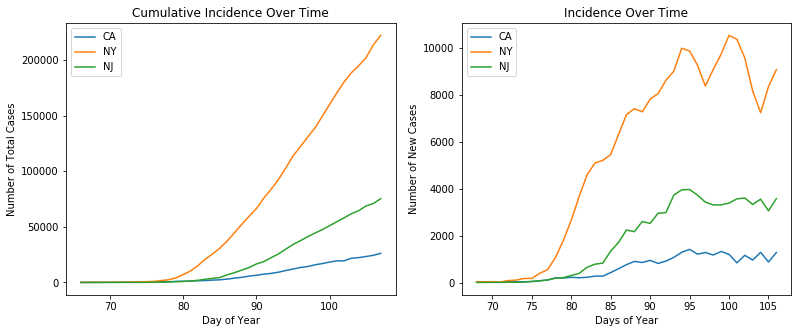

In [18]:
subset = ['CA','NY','NJ']

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(x_data,states_cumulative[subset]);
ax[0].set(xlabel='Day of Year',ylabel='Number of Total Cases',title='Cumulative Incidence Over Time')
ax[0].legend(subset)

ax[1].plot(x_data[states_inc_rolling3.index],states_inc_rolling3[subset]);
ax[1].set(xlabel='Days of Year',ylabel='Number of New Cases',title='Incidence Over Time')
ax[1].legend(subset)

plt.show()

And we can do the same for countries:

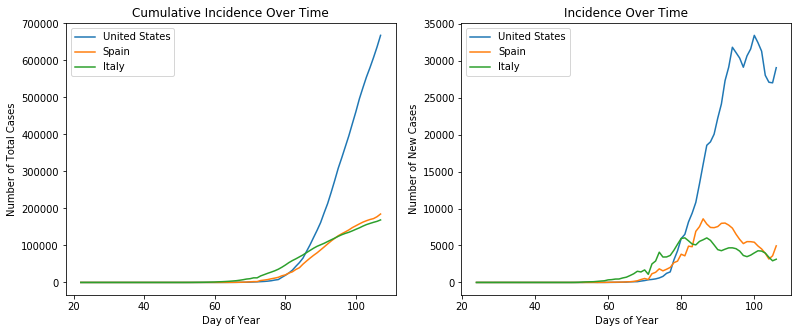

In [17]:
subset = global_cumulative.columns[:3]

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(x_data_global,global_cumulative[subset]);
ax[0].set(xlabel='Day of Year',ylabel='Number of Total Cases',title='Cumulative Incidence Over Time')
ax[0].legend(subset)

ax[1].plot(x_data_global[global_inc_rolling3.index],global_inc_rolling3[subset]);
ax[1].set(xlabel='Days of Year',ylabel='Number of New Cases',title='Incidence Over Time')
ax[1].legend(subset)

plt.show()

# Disease Modeling Basics

Before we go further let's clarify some terminology.

>**(Daily) incidence**: the number of new cases that are diagnosed every day. This represents how many new people are becoming infected every day.

>**Cumulative incidence**: the number of cumulative cases every day. This represents how many total people have been infected up until a certain day.

The graphs we just plotted above were the cumulative incidence over time and the incidence over time, respectively. They are two different representations of the same data; the former is just the sum of the latter. Mathematically speaking, the cumulative incidence at a certain day is the integral of the incidence up to that day. Equivalently, the incidence at a certain day is the derivative of the cumulative incidence on that day. This is important to understand for what follows.

You may notice that the cumulative incidence plots look like they are increasing exponentially. In the early days of the outbreak, experts warned the public about such *exponential growth* (exponential growth of a quantity means that the quantity rises faster and faster each day).

But wait! An important property of an exponential is that its derivative and integral is also an exponential. If the cumulative incidence over time were exponential, then the daily incidence would be, too. But you can clearly see in the graphs above that the daily incidence first increases and then decreases. It looks like a hump. In fact, the daily incidence somewhat resembles a *bell curve*.

You may even have seen coronavirus graphs in the news that look something like this:

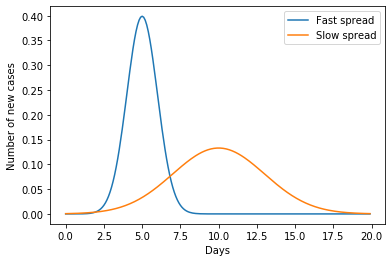

In [19]:
normal_1 = stats.norm(loc = 5, scale = 1) # gaussian with mean = 5, std = 1
normal_2 = stats.norm(loc = 10, scale = 3) # gaussian with mean = 10, std = 3
x = np.arange(0,20,0.1)
plt.plot(x,normal_1.pdf(x),x,normal_2.pdf(x)) # plot probability density functions
plt.xlabel('Days')
plt.ylabel('Number of new cases')
plt.legend(['Fast spread','Slow spread'])
plt.show()

Look's familiar right? Well, it turns out that when disease outbreaks happen, the daily incidence generally looks hump-shaped like that. The basic explanation is that in the beginning, very few people have the disease, but each person can infect several other people. The incidence increases rapidly as each new infected person infects many more people. Eventually, the incidence reaches a maximum. Let's define it:
>**Turning point**: the point at which the daily incidence reaches its maximum, or "flattens out".

The turning point can be thought of as a saturation point, where so many people have been infected that the amount of new people available to be infected starts getting smaller. This process continues, and the daily incidence continues to decrease until it reaches zero: the outbreak is over.

Great! We have a rough idea of what daily incidence numbers should look like over time. What should the cumulative incidence look like? Well, it's the integral of a bell curve:

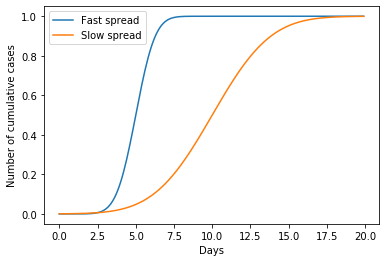

In [20]:
plt.plot(x,normal_1.cdf(x),x,normal_2.cdf(x)) # plot cumulative distribution functions
plt.xlabel('Days')
plt.ylabel('Number of cumulative cases')
plt.legend(['Fast spread','Slow spread'])
plt.show()

We see that the cumulative incidence is S-shaped and monotonically increasing – first rapid growth, then slow growth that approaches a plateau. Depending on how fast the spread of the disease is, the curve can be steeper or shallower. Also notice that the turning point, which was the maximum on the daily incidence graph, is the inflection point on the cumulative indicence graph.

Now, let's get more precise with our math. What we have illustrated above are actually examples of distributions of continous variables, with the following analogies:
>Daily incidence can be thought of as a **probability density function (PDF)**, which we call $\phi$

>Cumulative incidence can be thought of as a **cumulative distribution function (CDF)**, which we call $\Phi$

Generally speaking, for any hump-shaped PDF, we will observe a sigmoidal (S-shaped) CDF.

# Types of Models

The question now is the following: what mathematical function best describes our coronavirus data? We saw above that a bell curve seems like a reasonable guess for the PDF, but there might be other functions that look similar. So, we need to find a few reasonable functions and define their PDFs and CDFs.

There are at least three mathematical functions that are suitable:

>**Normal** distribution, also called a Gaussian distribution or bell-curve, defined by:

$$ \phi(t) = \frac{N}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}  (t-t_i)^2/\sigma^2 } $$ 
$$ \Phi(t) = \frac{N}{2} + \frac{N}{2} \operatorname{erf}\left(\frac{t-t_i}{\sigma \sqrt{2}}\right) $$

>**Logistic** distribution, commonly used in biological modeling, defined by:

$$ \phi(t) = \frac{N}{4s} \operatorname{sech}^2 \left( \frac{t-t_i}{2s} \right) $$ 
$$ \Phi(t) = \frac{N}{1 + e^{-(t-t_i)/s}} $$

>**Hyperbolic secant** distribution, also called the Gudermannian distribution, defined by:

$$ \phi(t) = \frac{N}{2} \operatorname{sech} \left( \frac{\pi (t-t_i)}{2s} \right) $$ 
$$ \Phi(t) = \frac{2 N}{\pi} \operatorname{arctan} \left(e^{(t-t_i)/s} \right) $$

where $N$ is the total number of people that will get infected, $t_i$ is the turning point, and $\sigma$ and $s$ are measures of the spread of the PDF. The error function, $\operatorname{erf}(x)$, is a special function that appears commonly in statistics but has no closed form.

Let's visualize these three distributions for $N=1$ and $t_i=10$. The values of $\sigma$ and $s$ aren't directly comparable between the distributions, so values might be different for each distribution.

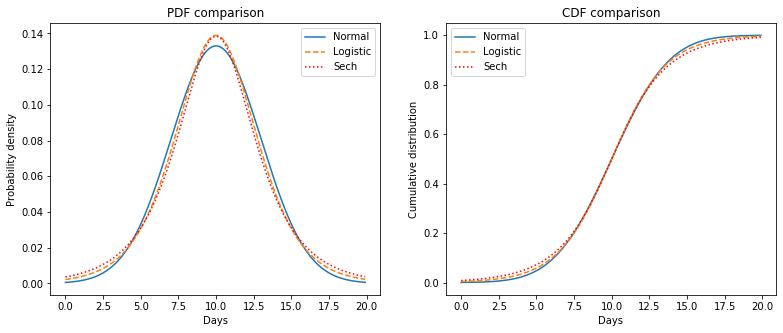

In [88]:
logistic_1 = stats.logistic(loc=10,scale=1.8)
gudermann_1 = stats.hypsecant(loc=10,scale=2.3)

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(x,normal_2.pdf(x),'-',x,logistic_1.pdf(x),'--',x,gudermann_1.pdf(x),'r:') # plot probability density functions
ax[0].set(xlabel='Days',ylabel='Probability density',title='PDF comparison')
ax[0].legend(['Normal','Logistic','Sech'])

ax[1].plot(x,normal_2.cdf(x),'-',x,logistic_1.cdf(x),'--',x,gudermann_1.cdf(x),'r:') # plot cumulative distribution functions
ax[1].set(xlabel='Days',ylabel='Cumulative distribution',title='CDF comparison')
ax[1].legend(['Normal','Logistic','Sech'])
plt.show()

You can see that the three distributions are very close to each other for this specific choice of parameters. The normal distribution has the thinnest tails, while the hyperbolic secant distribution has the thickest tails.

These curves are great for describing the indicence of an idealized disease. But one potential problem is that they are perfectly *symmetric*, which means that the incidence increases just as quickly as it decreases. However, we don't necessarily know that to be the case. In fact, we might expect that the incidence should decrease *more slowly* than it increases, because towards the end of an outbreak it takes longer and longer to find new people to infect. This *right skew* is in fact what is observed in many epidemics.

So, we may want to test some functions that are asymmetric. Luckily, there are some generalizations of the distributions described above that can introduce skew:

>**Skew normal** distribution, defined by:

$$ \phi(t) = \frac{N}{s \sqrt{2 \pi}} e^{-\frac{1}{2} (t-t_i)^2/s^2 } \left[ \frac{1}{2} + \frac{1}{2} \operatorname{erf}\left(\alpha \frac{t-t_i}{s \sqrt{2}}\right) \right] $$ 
$$ \Phi(t) = N \left[ \frac{1}{2} + \frac{1}{2} \operatorname{erf}\left(\frac{t-t_i}{\sigma \sqrt{2}}\right) - 2 T \left(\frac{t-t_i}{s},\alpha \right) \right] $$

>**Richards** curve, a type of generalized logistic curve, defined by:

$$ \Phi(t) = \frac{N}{\left(1 + e^{-(t-t_i)/s-ln(a)} \right)^{1/a}} $$

where $\alpha$ and $a$ are new parameters that describe the skewness. For a skew normal, Owen's T function, $T(h,\alpha)$, is a special function that has no closed form.

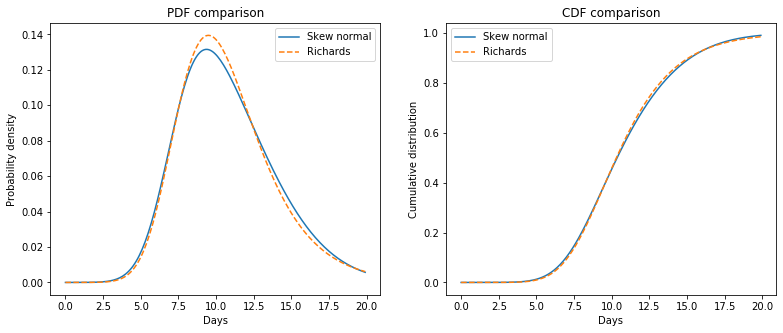

In [85]:
richards_1 = stats.genlogistic(c=9,loc=4,scale=2.5)
skewnorm_1 = stats.skewnorm(a=3,loc=7,scale=5)

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(x,skewnorm_1.pdf(x),'-',x,richards_1.pdf(x),'--') # plot probability density functions
ax[0].set(xlabel='Days',ylabel='Probability density',title='PDF comparison')
ax[0].legend(['Skew normal','Richards'])

ax[1].plot(x,skewnorm_1.cdf(x),'-',x,richards_1.cdf(x),'--') # plot cumulative distribution functions
ax[1].set(xlabel='Days',ylabel='Cumulative distribution',title='CDF comparison')
ax[1].legend(['Skew normal','Richards'])
plt.show()

Again, we see that the skew normal and the skew logistic (Richards) curves look pretty similar for the right choice of parameters. It's important to note that $\alpha=0$ corresponds to a regular normal curve, and a higher value of $\alpha$ indicates more right-skew. For the Richards curve, $a$ must always be positive and nonzero, but $a=1$ corresponds to a regular logistic curve, and a value  of $a$ closer to zero indicates more right-skew.

We've now identified five different mathematical functions: normal, skew normal, hyperbolic secant, logistic, and Richards. We can now attempt to fit these to coronavirus case data.

**Note**: theoretically there should be no difference whether you fit daily incidence data to a PDF or cumulative indicence data to a CDF. However, based on the initial graphs of real coronavirus data, you can see that daily incidence data is much less smooth. It has a significantly higher noise-to-signal ratio than the cumulative incidence data, so it will be more susceptible to overfitting and outlier influence. We should therefore perform our fits using the cumulative incidence data.

# Fitting the data

First I need to define several helper functions.
I create CDF and PDF functions which take two arguments: `x`, which is an array of the distributon parameters (`x=[N,mu,s]`), and `t`, which is an array of the time points. These functions all return the array of y values for that distribution at those time points.

In [70]:
def gaussian_cdf(t, N, t_i, s):
    return (N/2 * (1 + special.erf((t - t_i)/(s*sqrt(2)))))

def logistic_cdf(t, N, t_i, s):
    return (N / (1 + np.exp(-(t - t_i)/s)))

def gudermann_cdf(t, N, t_i, s):
    return N * (2/np.pi) * np.arctan(np.exp((t-t_i)/s))

def gauss_skew_cdf(t, N, mu, s, a):
    return N*(gaussian_cdf(t,1,mu,s)-2*special.owens_t(((t-mu)/s),a))

def richards_cdf(t, N, t_i, s, a):
    return N / (1 + np.exp(np.log(a)-(t-t_i)*a/s))**(1/a)


Next, I need a `regression` function that will fit my data to whichever model I specify. Here I use `scipy`'s least_squares function to find parameter weights that minimize the residuals. I also need a way of quantifying how closely my predictions match the actual data, so I define the root-mean-squared error `rmse`.

In [178]:
def get_params(model):
    return list(inspect.signature(model).parameters.keys())[1:]

def regression(model,x_test,y_test):
    
    def residual(x, t, y):
        return model(t,*x) - y
    
    x0 = [y_test.max()*1.2,x_test.max()*0.8,1]
    x_min = [y_test.max(),x_test.min(),0]
    x_max = [np.inf,np.inf,np.inf]
    if len(get_params(model)) == 4:
        x_min.append(0)
        if model.__name__ == 'gauss_skew_cdf':
            x0.append(0.1)
            x_max.append(10)
        elif model.__name__ == 'richards_cdf':
            x0.append(0.9)
            x_max.append(1)
    
    res_lsq = least_squares(residual, x0, bounds=(x_min,x_max),
            ftol=1e-10, xtol=1e-10, gtol=1e-10, loss='linear', args=(x_test, y_test))
    return res_lsq.x # returns array of parameter values

def rmse(y,y_hat):
    return np.sqrt(np.mean((y-y_hat)**2))

Finally, I define the function `fit_data` to iterate over every state or country and run `regression` on that region's case vs. time data. This function returns a dataframe with the predicted values of the parameters $N$, $\mu$, and $s$ for each region, as well as the RMSE. The dataframe also includes a plot comparing the model to the actual data for each region. 

In [179]:
def fit_data(df,regions,region_type,model,x_test):
    param_names = get_params(model)
    param_vals = [[] for i in range(len(param_names))]
    #N_vals = []
    #mu_vals = []
    #s_vals = []
    rmse_vals = []
    rmse_scaled_vals = []
    figs = []
    for item in regions:
        y_test = df[item].values
        params = regression(model,x_test,y_test)
        [param_vals[i].append(params[i]) for i in range(len(param_names))]
        #N_vals.append(params[0])
        #mu_vals.append(params[1])
        #s_vals.append(params[2])
        y_pred = model(x_test,*params)
        rmse_vals.append(rmse(y_test,y_pred))
        rmse_scaled_vals.append(rmse(y_test,y_pred)/max(y_test.max(),1))

        f = plt.figure()
        plt.plot(x_test,y_pred,'--')
        plt.plot(x_test,y_test)
        plt.xlabel('Day of Year')
        plt.ylabel('Cumulative Case Count')
        plt.title('Cases in '+item)
        plt.legend(['Model Fit','Actual Numbers'])
        figs.append(f)
        plt.close(f)
        
    fit_info = pd.DataFrame(index=regions,data={param_names[i]:param_vals[i] for i in range(len(param_names))})
    #fit_info['t_i'] = 
    fit_info['fig'] = figs
    fit_info['rmse'] = rmse_vals
    fit_info['rmse_scaled'] = rmse_scaled_vals
    fit_info.index.rename(region_type,inplace=True)
    fit_info.sort_values(by='N',ascending=False,inplace=True)
    
    return fit_info

Now I can go ahead and call `fit_data` on both my state data and my country data.

In [180]:
model_list = [gaussian_cdf,gauss_skew_cdf,logistic_cdf,richards_cdf,gudermann_cdf]

state_info = {m.__name__:fit_data(states_cumulative,states_list,'State',m,x_data.values) for m in model_list}

In [181]:
global_info = {m.__name__:fit_data(global_cumulative,top_countries,'Country',m,x_data_global.values) for m in model_list}

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in power



Here's what a few of the fitted logistics looked like:

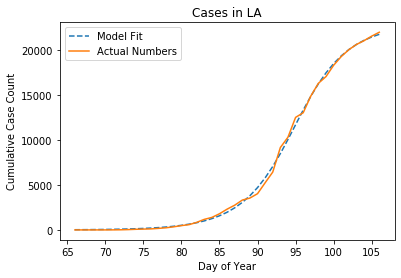

In [182]:
state_info['gudermann_cdf'].loc['LA','fig']

In [183]:
state_rmses = pd.DataFrame([m[1]['rmse'] for m in state_info.items()],index=state_info.keys())
state_rmses = (state_rmses-state_rmses.mean())/state_rmses.std()
#state_rmses['mean'] = state_rmses.mean(axis=1)
state_rmses.head()


,SD,NY,NJ,MA,MI,IL,PA,CA,FL,LA,...,WV,HI,MT,ND,WY,AK,GU,VI,MP,AS
gaussian_cdf,1.430833,-0.187182,-0.208958,-0.495706,-0.436021,-0.549610,-0.485521,-0.547423,-0.456613,1.071528,...,-0.709642,-0.391592,-0.201633,-0.257985,0.968086,-0.098859,-0.903960,-0.224593,0.550288,1.142532
gauss_skew_cdf,0.681630,-0.964339,-0.957564,-0.737464,-0.768033,-0.744528,-0.485521,-0.547423,-0.769210,1.071528,...,-0.709642,-0.391592,-0.932187,-0.958992,0.375152,-1.053820,-0.903960,-0.913059,-1.200205,0.822815
logistic_cdf,-0.705698,0.699503,0.675475,0.589338,0.630895,0.589451,-0.076826,0.159865,0.502739,-0.544664,...,0.064201,-0.283626,0.614564,0.633873,-0.309695,0.690759,0.297554,0.651939,0.719460,-0.660427
richards_cdf,-0.720645,-0.879330,-0.864111,-0.830439,-0.866184,-0.776342,-0.695415,-0.744533,-0.797261,-0.544664,...,-0.339948,-0.700254,-0.875684,-0.813432,-1.587298,-0.840454,0.001335,-0.891361,-0.966611,-1.256623
gudermann_cdf,-0.686120,1.331348,1.355158,1.474271,1.439343,1.481029,1.743283,1.679514,1.520345,-1.053726,...,1.695031,1.767063,1.394940,1.396536,0.553755,1.302374,1.509031,1.377074,0.897068,-0.048297


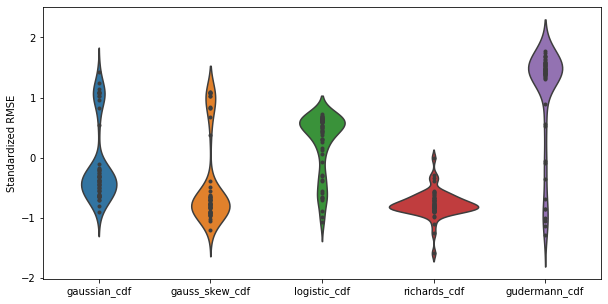

In [184]:
plt.figure(figsize=[10,5])
sns.violinplot(data=state_rmses.T,bw=0.3,inner='points');
plt.ylabel('Standardized RMSE');

In [185]:
global_rmses = pd.DataFrame([m[1]['rmse'] for m in global_info.items()],index=global_info.keys())
global_rmses = (global_rmses-global_rmses.mean())/global_rmses.std()
#state_rmses['mean'] = state_rmses.mean(axis=1)
global_rmses.head()

,Japan,Singapore,Qatar,Russia,United States,Peru,France,Spain,Italy,United Kingdom,...,Czechia,Australia,Philippines,Panama,Malaysia,Dominican Republic,Colombia,Finland,Luxembourg,Thailand
gaussian_cdf,1.174406,1.149982,0.930841,-0.726263,-0.450335,1.025138,-0.452491,-0.336342,-0.064704,-0.659152,...,-0.678088,1.315784,0.025695,-0.578079,-0.085317,-0.335742,-0.727388,-0.573570,0.240908,-0.204413
gauss_skew_cdf,1.012752,1.039001,0.847923,-0.726567,-0.807514,1.025138,-0.745549,-0.788909,-1.021482,-0.659152,...,-0.729712,0.286842,-0.983603,-0.679465,-1.067982,-0.836762,-0.727388,-0.668367,-1.098403,-0.774887
logistic_cdf,-0.736097,-0.739241,-0.116845,0.646037,0.640067,-0.395625,0.592526,0.562154,0.680809,0.364397,...,0.444751,-0.385078,0.482448,0.521811,0.685926,0.661414,0.160120,0.531544,0.711895,0.409121
richards_cdf,-0.710117,-0.706651,-0.116845,-0.645846,-0.819074,-0.395625,-0.860213,-0.899540,-0.894290,-0.650718,...,-0.601569,-1.414050,-0.921165,-0.785653,-0.832245,-0.888796,-0.372011,-0.804423,-0.980309,-0.945324
gudermann_cdf,-0.740944,-0.743091,-1.545075,1.452639,1.436855,-1.259026,1.465727,1.462637,1.299666,1.604624,...,1.564618,0.196502,1.396625,1.521386,1.299619,1.399886,1.666668,1.514816,1.125910,1.515503


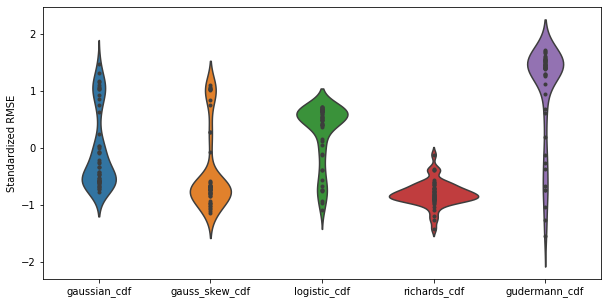

In [186]:
plt.figure(figsize=[10,5])
sns.violinplot(data=global_rmses.T,bw=0.3,inner='points');
plt.ylabel('Standardized RMSE');

# Results

I want to know if population plays a role here. So I need to merge the populations dataframes with my fitting results. I also want to see if quarantines had an effect, so I merge with those dataframes as well.

In [187]:
state_info = state_info['richards_cdf']
country_info = global_info['richards_cdf']

In [188]:
state_info = state_info.join(state_populations,on='State',how='left').join(state_quarantines[['Q_day']],on='State',how='left')

In [189]:
country_info = country_info.join(global_populations,on='Country',how='left').join(global_quarantines[['Q_day']],on='Country',how='left')

And now I can define a function that adds some new features. `N_per_1000` is is the number of cases per 1000 people in the country/state population, `Quarantine Headstart` is how early quarantine was started relative to the peak day `mu`, `N_on_Q_prop` is number of cases on the day quarantine was instituted relative to the final value of `N`,  `N_curr_prop` is the current number of cases relative to the final value of `N`, and `infection rate` is the inverse of `s`.

In [190]:
def add_features(df):
    df['N_per_1000'] = df['N'] / df['pop'] * 1000
    df['Quarantine Headstart'] = df['t_i'] - df['Q_day']
    df['N_on_Q_prop'] = richards_cdf(df['Q_day'],df['N'],df['t_i'],df['s'],df['a']) / df['N']
    df['N_curr_prop'] = richards_cdf(x_data.max(),df['N'],df['t_i'],df['s'],df['a']) / df['N']
    df['infection rate'] = 1 / df['s']
    return df

In [191]:
state_info = add_features(state_info)
country_info = add_features(country_info)

I realize that some of the fits may not be reliable if the country/state is still early in its infection progression. Here are a few of the countries and states that are not yet at their peaks:

In [192]:
state_info[state_info['N_curr_prop']<0.5][['N','t_i','s','a','N_curr_prop']].head()

,N,t_i,s,a,N_curr_prop
State,,,,,
SD,122901.849293,137.096721,6.287793,0.778207,0.009485
MA,78825.389727,105.405884,0.030400,0.001940,0.382164
IL,54661.868007,102.954577,0.571370,0.040215,0.451922
CT,32402.570963,103.267874,1.093328,0.088730,0.461192
AL,12607.457691,107.741425,0.005520,0.000311,0.331870


In [193]:
country_info[country_info['N_curr_prop']<0.5][['N','t_i','s','a','N_curr_prop']].head()

,N,t_i,s,a,N_curr_prop
Country,,,,,
Japan,3.630431e+06,175.409638,11.415653,1.000000,0.002282
Russia,3.591171e+06,158.555933,3.405413,0.125625,0.006766
Singapore,1.881989e+06,176.804860,11.222505,0.999803,0.001817
France,5.014247e+05,113.399197,0.001433,0.000055,0.265253
Ireland,4.318342e+05,161.630405,0.639240,0.014882,0.028560


Therefore, for making conclusions I will only use data from states and countries that are currently at least halfway through the outbreak, i.e. they have passed their peak day where `N_curr_prop` $=0.5$.

In [194]:
country_plottable = country_info[country_info['N_curr_prop']>0.5].dropna().copy()
state_plottable = state_info[state_info['N_curr_prop']>0.5].dropna().copy()

Let's visualize which states and countries have the highest infection rates per population:

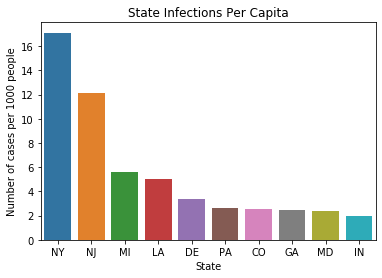

In [195]:
state_plottable.sort_values(by='N_per_1000',ascending=False,inplace=True)
sns.barplot(x=state_plottable.index[:10],y=state_plottable['N_per_1000'][:10])
plt.ylabel('Number of cases per 1000 people');
plt.title('State Infections Per Capita');

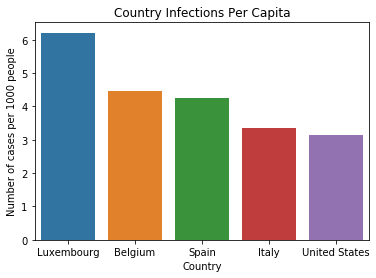

In [196]:
country_plottable.sort_values(by='N_per_1000',ascending=False,inplace=True)
sns.barplot(x=country_plottable.index[:5],y=country_plottable['N_per_1000'][:5])
plt.ylabel('Number of cases per 1000 people');
plt.title('Country Infections Per Capita');

We can also visualize the quarantine effectiveness for different states and countries:

In [197]:
fig = px.scatter(country_plottable, x='Quarantine Headstart', y='infection rate', 
                 hover_name=country_plottable.index.to_series(),
                 trendline='ols',width=500,height=400,
                 title='Quarantine Effectiveness by Country')
fig.update_yaxes(title="Infection Rate (speed of spread)")
fig.update_xaxes(title="Quarantine Headstart (days)")
fig.show()

In [198]:
fig = px.scatter(state_plottable, x='Quarantine Headstart', y='infection rate', 
                 hover_name=state_plottable.index.to_series(),
                 trendline='ols',width=500,height=400,
                 title='Quarantine Effectiveness by State')
fig.update_yaxes(title="Infection Rate (speed of spread)")
fig.update_xaxes(title="Quarantine Headstart (days)")
fig.show()

In [199]:
plottable = state_plottable.append(country_plottable)
#plottable = country_plottable
fig = px.scatter(plottable, x='N_on_Q_prop', y='N_per_1000', 
                 hover_name=plottable.index.to_series(),
                 trendline=None,width=500,height=400, log_x=True, log_y=True,
                 title='Quarantine Effectiveness')
#fig.update_yaxes(title="Infection Rate (speed of spread)")
#fig.update_xaxes(title="Quarantine Headstart (days)")
fig.show()